In [1]:
# the goal of this notebook is to replicate the results of Duvall et al., 2004
# the main focus is to evaluate whether or not channels that include gravel clasts
# that are more resistant than the substrate over which they flow
# exhibit oversteepened donwstream profiles

# a secondary goal for the day/week (or something to discuss at group meeting tomorrow)
# is to figure out how to explicitly put grainsize in my model

# but for now, just focus on trying to run a couple different simple model runs

In [2]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# SET UP GRID ARRAYS
dx = 1000
x = np.arange(0, 100000, dx)

# set up runoff rate
r = np.zeros(len(x))
r[:] = 0.3 # runoff rate in m/yr, see Rossi et al 2016 supplemental

# set up references to topography
Hstar = 0.05 # "a thin and scattered blanket of alluvium"
H = Hstar + np.zeros(len(x))
etab = -H
eta = etab + H

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig = np.zeros(len(x))
beta_ig[:25] = 0.00004
beta_sed = np.zeros(len(x))
beta_sed[25:] = 0.00014
atr_factor = 0.00004

# erodibility values
k_ig = np.zeros(len(x))
k_ig[:25] = 0.000022 # dropping an order of magnitude for incorporation of harder rocks # needs 1 more zeros
k_sed = np.zeros(len(x))
k_sed[25:] = 0.00022 # based on erodibility value from Duvall et al, calibrated using Barnhart et al 2020 # ditto

# other
c_factor = 0.041
uplift_rate = 0.0014

In [4]:
# write a function that has two bedrock lithologies in the domain, but only one contributing sediment to bedload
def two_lith_one_sed(x,
                     dx,
                     Hstar,
                     H,
                     etab,
                     eta,
                     beta_ig,
                     beta_sed,
                     atr_factor,
                     k_ig,
                     k_sed,
                     r,
                     c = 0.041, # from W & S '19, assuming I = 1 (constant geomorphically effective flow)
                     baselevel_rate = 0.0014, # average low uplift rate from duvall et al
                     num_steps = 1000000, 
                     porosity = 0.55):
    
    H[-1] = 0.0
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    sedimentation_rate = np.zeros(len(x))
    total_ero = np.zeros(len(x))
    total_ero[-1] = baselevel_rate
    q = r * x  # discharge = distance downstream (first node is left edge of 0th cell)
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt_global = 0.2 * dx * dx / (c*q[-1])  # "global" time-step size # mult by 0.2
    run_duration = dt_global * num_steps  # <== here's how long we want to run
    cum_time = 0.0  # <== keep track of elapsed time

    #for i in range(num_steps):
    while cum_time < run_duration:  # <== use a while loop because dt varies by iteration
        

        # first calculate rates
        
        #  calc slope
        S = -np.diff(eta)/dx
        
        #  calculate e factor
        efac = np.exp(- H / Hstar)
        
        #  calculate total bedload sed flux and set boundary condition
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1])
        qs[0] = 0
        
        #  calc bedrock erosion from stream power (plucking)
        ero_plucking_ig = efac[:-1] * (k_ig[1:] * q[1:] * S)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        #  calc bedrock erosion from abrasion
        ero_ab_ig = efac[:-1] * (beta_ig[:-1] * qs[1:])   # <== change indexing: qs[1] represents node 0
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[1:])
        
        #  calc bedrock erosion rate from stream power and abrasion
        bedrock_ero[:-1] = ero_plucking_ig + ero_plucking_sed + ero_ab_ig + ero_ab_sed
        
        #  calc grain attrition rate
        atr = atr_factor * qs[1:]
        
        #  calc rate of change in alluvial thickness
        sedimentation_rate[:-1] = -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_ig))
        
        
        # Calculate maximum allowable time-step size
        
        #  track total erosion rate
        total_ero[:-1] = bedrock_ero[:-1] - sedimentation_rate[:-1]  # <== erosion is MINUS sed rate
        
        #  set adaptive timestep
        #  first check time to flat surface
        elev_diff = np.diff(eta)/dx
        ero_diff = np.diff(total_ero)/dx
        #valid_places = np.where(ero_diff < 0)
        valid_places = np.where(ero_diff < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(valid_places) > 0:  # <== in case there ARE no locations...
            times_to_flat = np.abs(elev_diff[valid_places]/ero_diff[valid_places])
        else:
            times_to_flat = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_flat = np.amin(times_to_flat)

        #  then check time to deplete all sediment
        #sed_depletion_locations = np.where(sedimentation_rate < 0)
        sed_depletion_locations = np.where(sedimentation_rate < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(sed_depletion_locations) > 0:  # <== in case there ARE no locations...
            times_to_no_sed = np.abs(H[sed_depletion_locations]/sedimentation_rate[sed_depletion_locations])
        else:
            times_to_no_sed = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_no_sed = np.amin(times_to_no_sed)

        #  check for smaller condition
        dt = min(min_time_to_flat, min_time_to_no_sed)

        #  if larger than global step size, limit to global
        dt = min(dt, dt_global)
        
        
        # Update quantities
        
        #  lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        #  set boundary conditions
        etab[-1] = eta[-1]
        
        #  calc change in bedrock elev
        etab[:-1] -= bedrock_ero[:-1] * dt
        
        #  update sediment thickness
        H[:-1] += sedimentation_rate[:-1] * dt
        H[H < 0] = 0

        #  update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
        # Advance time
        cum_time += dt
        
        if any(total_ero[:] != baselevel_rate):
            continue
        else:
            break
            
    print(cum_time)
        
    return (q, S, qs, efac, eta, etab, ero_plucking_ig, ero_plucking_sed, ero_ab_ig, ero_ab_sed, bedrock_ero, atr, 
            sedimentation_rate, H, total_ero, cum_time)

In [5]:
# EXP 1

exp_1a = [x, dx, Hstar, H, etab, eta, beta_ig, beta_sed, atr_factor, k_ig, k_sed, r, c_factor, uplift_rate, 50000]

In [6]:
# run exp 1

(discharge_exp_1a,
 slope_exp_1a,
 sed_flux_exp_1a,
 e_factor_exp_1a,
 topography_exp_1a,
 bedrock_elevation_exp_1a,
 igneous_plucking_rate_exp_1a,
 sedimentary_plucking_rate_exp_1a,
 igneous_abrasion_rate_exp_1a,
 sedimentary_abrasion_rate_exp_1a,
 bedrock_erosion_rate_exp_1a,
 attrition_rate_exp_1a,
 sedimentation_rate_exp_1a,
 sediment_thickness_exp_1a,
 total_erosion_rate_exp_1a,
 cum_time_exp_1a) = two_lith_one_sed(*exp_1a)

8212206.959606423


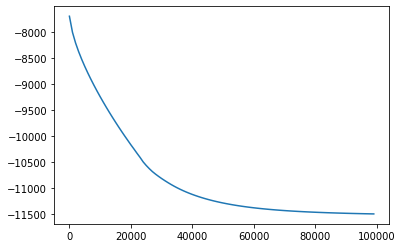

In [7]:
plt.plot(x, eta)
# plt.vlines(25000, -10000, 0)

In [8]:
total_erosion_rate_exp_1a

array([ 0.00138128,  0.00138388,  0.00138529,  0.00138633,  0.00138715,
        0.00138796,  0.00138857,  0.00138892,  0.00138926,  0.00138991,
        0.00139138,  0.00139488,  0.00139955,  0.00140613,  0.0014024 ,
        0.00132104,  0.00109752,  0.00712836,  0.00297448, -0.04519428,
        0.03976032,  0.0041608 ,  0.00070578,  0.00805427, -0.00642767,
       -0.00114157, -0.00075654, -0.00246074, -0.00045189,  0.00062895,
        0.00051899,  0.00079885,  0.00188199,  0.00236467,  0.0021068 ,
        0.00160773,  0.00123605,  0.00109184,  0.00106293,  0.00107034,
        0.00108711,  0.00110634,  0.00112711,  0.00115001,  0.00117562,
        0.001204  ,  0.00123457,  0.00126621,  0.00129749,  0.00132693,
        0.00135327,  0.00137564,  0.00139366,  0.00140738,  0.00141715,
        0.0014235 ,  0.00142703,  0.00142845,  0.00142859,  0.00142844,
        0.00142917,  0.00143191,  0.00143764,  0.00144688,  0.00145951,
        0.00147469,  0.00149094,  0.00150642,  0.00151933,  0.00

In [9]:
# okay, wahoo! 
# now we want to see if gradients in soft portion are oversteepened in this setting
# relative to a scenario where there are no impactors
# but to really examine that, first need to get this baby to steady state
# going back now to try a larger timestep

In [69]:
# okay, now let's go out on a limb and calculate some channel widths
# using the formulation b = k_b * (q/attrition_rate)

kb = 2.61
area = x ** 2

b = kb * (discharge_exp_1a[22:] / attrition_rate_exp_1a[21:])

Text(0, 0.5, 'width?? (m)')

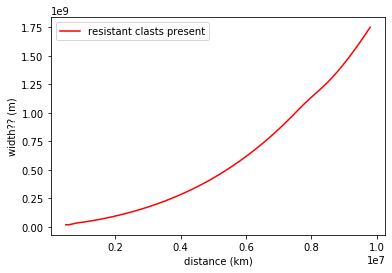

In [70]:
plt.plot(area[22:]/1000, b, label = 'resistant clasts present', color = 'r')
plt.legend()
plt.xlabel('distance (km)')
plt.ylabel('width?? (m)')

/Users/vanessa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in power
/Users/vanessa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/vanessa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in power
/Users/vanessa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/Users/vanessa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in power
/Users/vanessa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


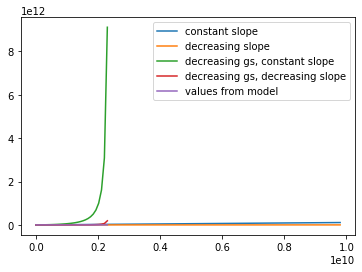

In [83]:
# trying to get my head around all the different ways to do "width"

# set up grain fining
d = 0.002
abrasion_factor = np.zeros(len(x))
abrasion_factor[:] = 0.00004
multiplier_array = np.zeros(len(x))
multiplier_array[:] = np.arange(1, 101, 1)
fining = abrasion_factor * multiplier_array

new_d = d - fining

# constant slope, constant gs, length - area scaling
s = 0.001
width = (area * slope) / (d**(3/2))

# slope is decreasing like 1/x
width_2 = x/(d**(3/2))

# using wickert and schildgen formulation, Q ~ x^2, decreasing grain size, constant slope
width_3 = (area * slope) / (new_d**(3/2))

# or W&S with decreasing slope
width_4 = x / (new_d**(3/2))

# using values from model output
width_5 = kb * (discharge_exp_1a[1:] * slope_exp_1a[:] / new_d[1:]**(3/2))


plt.plot(area, width, label = 'constant slope')
plt.plot(area, width_2, label = 'decreasing slope')
plt.plot(area, width_3, label = 'decreasing gs, constant slope')
plt.plot(area, width_4, label = 'decreasing gs, decreasing slope')
plt.plot(area[1:], width_5, label = 'values from model')
plt.legend()

In [ ]:
eta_2 = np.zeros(len(x))
k_sed_2 = np.zeros(len(x))
k_sed_2[:] = 0.00022

exp_2a = [x, dx, eta_2, k_sed_2, r, c_factor, uplift_rate, 50000]

In [ ]:
# now write another function that's just stream power over soft rocks

def stream_power(x,
                 dx,
                 eta,
                 k_sed,
                 r,
                 c = 0.041, # from W & S '19, assuming I = 1 (constant geomorphically effective flow)
                 baselevel_rate = 0.0014, # average low uplift rate from duvall et al
                 num_steps = 1000000, 
                 porosity = 0.55):
    
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    bedrock_ero[-1] = baselevel_rate
    q = r * x  # discharge = distance downstream (first node is left edge of 0th cell)
    dt = 0.2 * dx * dx / (c*q[-1])  # "global" time-step size # mult by 0.2
    run_duration = dt * num_steps  # <== here's how long we want to run
    cum_time = 0.0  # <== keep track of elapsed time
    
    while cum_time < run_duration:
    
    # for i in range(num_steps):

        # first calculate rates
        
        #  calc slope
        S = -np.diff(eta)/dx
        
        #  calc bedrock erosion from stream power (plucking)
        bedrock_ero[:-1] = k_sed[1:] * q[1:] * S
        
        #  lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        #  calc change in bedrock elev
        eta[:-1] -= bedrock_ero[:-1] * dt
        
        # Advance time
        cum_time += dt
    
        
        if any(bedrock_ero[:] != baselevel_rate):
            continue
        else:
            break
            
    print(cum_time)
            
        
    return (q, S, bedrock_ero, eta, cum_time)

In [ ]:
# run exp 2

(discharge_exp_2a,
 slope_exp_2a,
 bedrock_erosion_rate_exp_2a,
 topography_exp_2a,
 cum_time_exp_2a) = stream_power(*exp_2a)

In [ ]:
plt.plot(x, topography_exp_2a)

In [ ]:
plt.plot(x[24:]/1000, slope_exp_1a[23:], color = 'r', label = 'resistant clasts present')
plt.plot(x[24:]/1000, slope_exp_2a[23:], color = 'k', label = 'no clasts present')
plt.xlabel('distance (km)')
plt.ylabel('slope')
plt.vlines(24, 0, 0.09, linestyle = '--', label = 'lithologic contact')
plt.legend()

In [ ]:
# okay, this shows a result similar to Duvall et al in that slopes are steeper downstream of the contact
# can't really compare widths because there is no grain attrition in this function

In [ ]:
k_sed_3 = np.zeros(len(x))
k_sed_3[:] = 0.00022

H_3 = Hstar + np.zeros(len(x))
etab_3 = -H
eta_3 = etab_3 + H_3

beta_sed_3 = np.zeros(len(x))
beta_sed_3[:] = 0.00014

exp_3a = [x, dx, Hstar, H_3, etab_3, eta_3, beta_sed_3, k_sed_3, r, c_factor, uplift_rate, 1]

In [ ]:
# okay, now make a function similar to the first, but has grains in it, but all grains are soft

def one_lith_one_sed(x,
                     dx,
                     Hstar,
                     H,
                     etab,
                     eta,
                     beta_sed,
                     atr_factor,
                     k_sed,
                     r,
                     c = 0.041, # from W & S '19, assuming I = 1 (constant geomorphically effective flow)
                     baselevel_rate = 0.0014, # average low uplift rate from duvall et al
                     num_steps = 1000000, 
                     porosity = 0.55):
    
    H[-1] = 0.0
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    sedimentation_rate = np.zeros(len(x))
    total_ero = np.zeros(len(x))
    total_ero[-1] = baselevel_rate
    q = r * x  # discharge = distance downstream (first node is left edge of 0th cell)
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt_global = 0.2 * dx * dx / (c*q[-1])  # "global" time-step size # mult by 0.2
    run_duration = dt_global * num_steps  # <== here's how long we want to run
    cum_time = 0.0  # <== keep track of elapsed time

    #for i in range(num_steps):
    while cum_time < run_duration:  # <== use a while loop because dt varies by iteration
        

        # first calculate rates
        
        #  calc slope
        S = -np.diff(eta)/dx
        
        #  calculate e factor
        efac = np.exp(- H / Hstar)
        
        #  calculate total bedload sed flux and set boundary condition
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1])
        qs[0] = 0
        
        #  calc bedrock erosion from stream power (plucking)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        #  calc bedrock erosion from abrasion
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[1:])
        
        #  calc bedrock erosion rate from stream power and abrasion
        bedrock_ero[:-1] = ero_plucking_sed + ero_ab_sed
        
        #  calc grain attrition rate (attrition factor is same as sedimentary rock abrasion rate)
        atr = beta_sed * qs
        
        #  calc rate of change in alluvial thickness
        sedimentation_rate[:-1] = -((1 / porosity) * ((np.diff(qs)/dx) + atr[1:] - ero_plucking_sed))
        
        
        # Calculate maximum allowable time-step size
        
        #  track total erosion rate
        total_ero[:-1] = bedrock_ero[:-1] - sedimentation_rate[:-1]  # <== erosion is MINUS sed rate
        
        #  set adaptive timestep
        #  first check time to flat surface
        elev_diff = np.diff(eta)/dx
        ero_diff = np.diff(total_ero)/dx
        #valid_places = np.where(ero_diff < 0)
        valid_places = np.where(ero_diff < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(valid_places) > 0:  # <== in case there ARE no locations...
            times_to_flat = np.abs(elev_diff[valid_places]/ero_diff[valid_places])
        else:
            times_to_flat = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_flat = np.amin(times_to_flat)

        #  then check time to deplete all sediment
        #sed_depletion_locations = np.where(sedimentation_rate < 0)
        sed_depletion_locations = np.where(sedimentation_rate < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(sed_depletion_locations) > 0:  # <== in case there ARE no locations...
            times_to_no_sed = np.abs(H[sed_depletion_locations]/sedimentation_rate[sed_depletion_locations])
        else:
            times_to_no_sed = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_no_sed = np.amin(times_to_no_sed)

        #  check for smaller condition
        dt = min(min_time_to_flat, min_time_to_no_sed)

        #  if larger than global step size, limit to global
        dt = min(dt, dt_global)
        
        
        # Update quantities
        
        #  lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        #  set boundary conditions
        etab[-1] = eta[-1]
        
        #  calc change in bedrock elev
        etab[:-1] -= bedrock_ero[:-1] * dt
        
        #  update sediment thickness
        H[:-1] += sedimentation_rate[:-1] * dt
        H[H < 0] = 0

        #  update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
        # Advance time
        cum_time += dt
        
        if any(total_ero[:] != baselevel_rate):
            continue
        else:
            break
            
    print(cum_time)
        
    return (q, S, qs, efac, eta, etab, ero_plucking_sed, ero_ab_sed, bedrock_ero, atr, sedimentation_rate, H, 
            total_ero, cum_time)

In [ ]:
(discharge_exp_3a,
 slope_exp_3a,
 sed_flux_exp_3a,
 e_factor_exp_3a,
 topography_exp_3a,
 bedrock_elevation_exp_3a,
 sedimentary_plucking_rate_exp_3a,
 sedimentary_abrasion_rate_exp_3a,
 bedrock_erosion_rate_exp_3a,
 attrition_rate_exp_3a,
 sedimentation_rate_exp_3a,
 sediment_thickness_exp_3a,
 total_erosion_rate_exp_3a,
 cum_time_exp_3a) = one_lith_one_sed(*exp_3a)